## Exercícios 2 e 3

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def thomas(data):
    N = data.A.size
    C_prime = np.zeros(N)
    D_prime = np.zeros(N)
    for i in xrange(1,N+1):
        if (i==1):
            C_prime[i-1] = data.C[i-1] / data.B[i-1]
            D_prime[i-1] = data.D[i-1] / data.B[i-1]
        else:
            C_prime[i-1] = data.C[i-1] / (data.B[i-1]-(data.A[i-1]*C_prime[i-2]))
            D_prime[i-1] = (data.D[i-1]-(data.A[i-1]*D_prime[i-2])) / \
                           (data.B[i-1]-(data.A[i-1]*C_prime[i-2]))
            
    x = np.zeros(N)
    for i in xrange(N-1,-1,-1):
        if (i==N-1):
            x[i] = D_prime[i]
        else:
            x[i] = D_prime[i] - (C_prime[i]*x[i+1])
    return C_prime,D_prime,np.round(x,4)

In [20]:
path = './src/data.txt'
data = pd.read_csv(path,sep='\t',dtype=float)
data['C_prime'],data['D_prime'],data['c_k'] = thomas(data)

In [21]:
data.head(20)

,A,B,C,D,C_prime,D_prime,c_k
0,0.0000,4.4258,7.2007,37.4490,1.626983,8.461521,3.2210
1,1.7557,4.4258,7.2007,62.8916,4.588460,30.609513,3.2210
2,9.8515,5.3964,7.2893,78.2298,-0.183117,5.610090,5.9690
3,5.0398,6.2351,3.2890,74.7451,0.459488,6.492253,1.9600
4,0.7593,3.5378,9.6730,120.2838,3.033324,36.173550,9.8637
5,5.7762,9.0621,0.9250,139.4377,-0.109351,8.217056,8.6736
6,8.8807,5.3009,4.3282,116.3878,0.690081,6.921952,4.1751
7,9.4295,2.3142,1.7413,53.8097,-0.415295,2.733380,3.9805
8,3.3948,5.2373,2.3549,30.1569,0.354272,3.140841,3.0029
9,3.0899,5.7860,9.3674,37.8386,1.996746,5.996955,0.3893


## Exercício 4

Resolver o problema de contorno usando o método de elementos finitos
$$ -\frac{d^2 y}{d x^2} + 20 \frac{dy}{dx} + 10 y(x)-1=0 $$
com as condições de contorno essenciais
$$y(0)=0 \:\:\: y(1)=0$$

In [22]:
def baseUp(x):
    x0, x1 = x[0],x[-1]
    w = (x-x0) / (x1-x0)
    dw = 1.0 / (x1-x0)
    return w,dw

def baseDw(x):
    x0, x1 = x[0],x[-1]
    w = 1 - (x-x0) / (x1-x0)
    dw = - 1.0 / (x1-x0)
    return w,dw

def calcIntegral(y,dx):
    aux = y[1:-1] * dx
    r = np.sum(aux)
    r = r + (y[0]*dx/2.) + (y[-1]*dx/2.)
    return r

def calcK(wA,dwA,wB,dwB):
    auxK = (dwA*dwB) + (20.*wA*dwB) + (10.*wA*wB)
    return auxK

def rigidity(N,x):
    K = np.zeros(shape=(N,2,2))
    w = np.zeros(shape=(2,np.size(x[0])))
    dw = np.zeros(shape=(2,np.size(x[0])))
    for e in xrange(N):
        for n in xrange(2):
            for m in xrange(2):
                w[0],dw[0] = baseDw(x[e])
                w[1],dw[1] = baseUp(x[e])
                if (e%2==0):                    
                    auxK = calcK(w[n],dw[n],w[m],dw[m])
                    K[e,n,m] = calcIntegral(auxK,x[e,1]-x[e,0])
                else:
                    auxK = calcK(w[n],dw[n],w[m],dw[m])
                    K[e,n,m] = calcIntegral(auxK,x[e,1]-x[e,0])
    return K

def force(N,x):
    F = np.zeros(N)
    wAUX,dwAUX = baseDw(x[0])
    F[0] = calcIntegral(wAUX,x[0,1]-x[0,0])
    wAUX,dwAUX = baseUp(x[-1])
    F[-1] = calcIntegral(wAUX,x[-1,1]-x[-1,0])
    for e in xrange(1,N-1):
        wUP,dwUP = baseUp(x[e-1])
        wDW,dwDW = baseDw(x[e])
        F[e] = calcIntegral(wUP,x[e-1,1]-x[e-1,0]) + calcIntegral(wDW,x[e,1]-x[e,0])
    return F

In [23]:
N = 50
a = 0.0
b = 1.0

nn = 1001

x = np.zeros(shape=(N,nn))
for e in xrange(N):
    x[e] = np.linspace(e*b/N,(e+1)*b/N,nn)
    
K = rigidity(N,x)
F = force(N+1,x)

# print K

#condicoes de contorno
K[0,0,0] = 1.
K[0,0,1] = 0.
K[-1,-1,1] = 1.
K[-1,-1,0] = 0.
F[0] = 0.
F[-1] = 0.

In [24]:
path2 = './src/exercicio4.txt'
f = open(path2,'w')
f.write("A\tB\tC\tD\n")
f.write("0\t"+str(K[0,0,0])+"\t"+str(K[0,0,1])+"\t"+str(F[0])+"\n")
for e in xrange(N-1):
    aux1 = K[e,1,0]
    aux2 = K[e,1,1] + K[e+1,0,0]
    aux3 = K[e+1,0,1]
    aux4 = F[e+1]
    f.write(str(aux1)+"\t"+str(aux2)+"\t"+str(aux3)+"\t"+str(aux4)+"\n")
f.write(str(K[-1,-1,0])+"\t"+str(K[-1,-1,1])+"\t0.0\t"+str(F[-1])+"\n")
f.close()

In [25]:
e = 2.71828182846
x = np.linspace(0,1,N+1)

aux1 = -e**10. + e**np.sqrt(110.)
aux2 = e**((10.+np.sqrt(110.))*x)
aux3 = 10.*(e**10.)*(1.-e**(2.*np.sqrt(110.)))

aux4 = e**(-10.+np.sqrt(110.))
aux5 = e**(10.+np.sqrt(110.)) -1.
aux6 = e**((10.-np.sqrt(110.))*x)
aux7 = 10.*(1.-e**(2.*np.sqrt(110.)))

y = (aux1*aux2/aux3) + (aux4*aux5*aux6/aux7) + 1./10.

path = './src/exercicio4.txt'
data = pd.read_csv(path,sep='\t',dtype=float)
data['C_prime'],data['D_prime'],data['c_k'] = thomas(data)

data.head()

,A,B,C,D,C_prime,D_prime,c_k
0,0.000000,1.000000,0.000000,0.00,0.000000,0.000000,0.0000
1,-59.966667,100.133333,-39.966667,0.02,-0.399134,0.000200,0.0010
2,-59.966667,100.133333,-39.966667,0.02,-0.524507,0.000420,0.0019
3,-59.966667,100.133333,-39.966667,0.02,-0.581922,0.000658,0.0029
4,-59.966667,100.133333,-39.966667,0.02,-0.612634,0.000911,0.0038


In [26]:
data.tail()

,A,B,C,D,C_prime,D_prime,c_k
46,-59.966667,100.133333,-39.966667,0.02,-0.660007,0.011890,0.0288
47,-59.966667,100.133333,-39.966667,0.02,-0.660007,0.012105,0.0257
48,-59.966667,100.133333,-39.966667,0.02,-0.660007,0.012318,0.0206
49,-59.966667,100.133333,-39.966667,0.02,-0.660007,0.012528,0.0125
50,0.000000,1.000000,0.000000,0.00,0.000000,0.000000,0.0000


(0.03217861744836471, 0.0322)


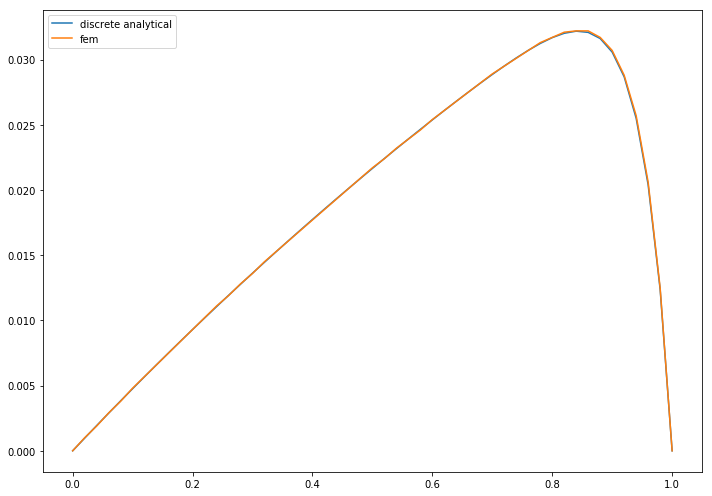

In [27]:
xx = np.linspace(0,1,N+1)

plt.figure(figsize=(10,7))
plt.plot(x,y,"-",label="discrete analytical")
plt.plot(x,data.c_k,"-",label="fem")

plt.legend()
plt.tight_layout()
print(y.max(),data.c_k.max())

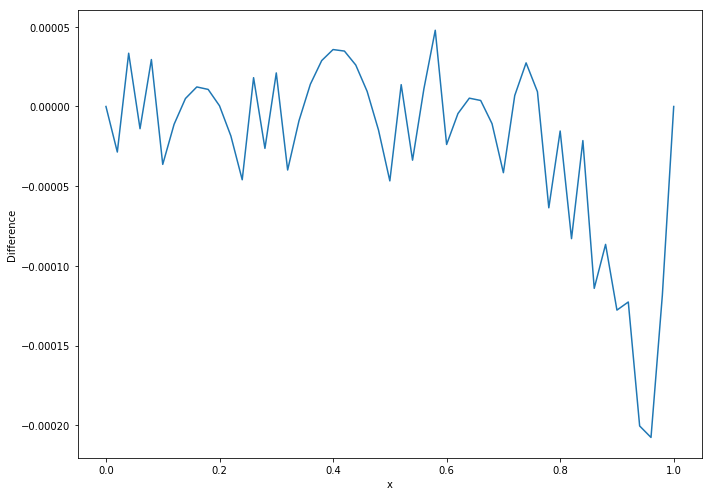

In [28]:
plt.figure(figsize=(10,7))
plt.plot(x,(y[xx==x]-data.c_k))
plt.xlabel("x")
plt.ylabel("Difference")
plt.tight_layout()